# Polocy Gradient using Pytorch
- Sungjin (James) Kim, 2019

In [1]:
%matplotlib inline
# Using ipython
from IPython.display import clear_output

import gym
import random
from itertools import count
import numpy as np
import matplotlib.pyplot as plt

# Using torch
import torch as TC
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli

In [2]:
def list_norm_inplace(buff):
    r_mean = np.mean(buff)
    r_std = np.std(buff)
    for ii in range(len(buff)):
        buff[ii] = (buff[ii] - r_mean) / r_std

        
def plot_durations(episode_durations):
    plt.figure(2)
    plt.clf()
    durations_t = TC.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = TC.cat((TC.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()
    
        
def plot_durations_ii(ii, episode_durations, ee, ee_duration=100):
    episode_durations.append(ii+1)
    if (ee + 1) % ee_duration == 0:
        clear_output()
        plot_durations(episode_durations)
    
    
class PGNET(nn.Module):
    # 순수하게 Policy gradient로 구성
    def __init__(self, num_state):
        super(PGNET, self).__init__()
    
        self.fc_in = nn.Linear(num_state, 24)
        self.fc_hidden = nn.Linear(24, 36)
        self.fc_out = nn.Linear(36, 1)
        
    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc_hidden(x))
        x = TC.sigmoid(self.fc_out(x))
        return x

In [3]:
class PGNET_MACHINE(PGNET):
    # Policy gradient를 실제 사용하기 위해 필요한 변환을 고려함
    def __init__(self, num_state, render_flag=False):
        self.forget_factor = 0.99
        self.learning_rate = 0.01
        self.num_episode = 5000            
        self.num_batch = 5
        self.render_flag = render_flag
        self.steps_in_batch = 0
        self.episode_durations = []
        
        super(PGNET_MACHINE, self).__init__(num_state)                
        self.optimizer = TC.optim.RMSprop(self.parameters(), lr=self.learning_rate)        
        self.init_buff()        
        
    def forward(self, state):
        state_var = Variable(TC.from_numpy(state).float())
        prob = super(PGNET_MACHINE, self).forward(state_var)
        # check this function to know what the meaing of log_prob. Is it log(prob)?
        return Bernoulli(prob)
    
    def push_buff_done(self, reward, state, action, done_flag=False):
        if done_flag: # devide between episodes
            self.reward_buff.append(0)
        else:
            self.reward_buff.append(reward)
        self.state_buff.append(state)
        self.action_buff.append(action)
        
    def pull_buff(self, ii):
        return self.reward_buff[ii], self.state_buff[ii], self.action_buff[ii]
    
    def init_buff(self):
        self.reward_buff = []
        self.state_buff = []
        self.action_buff = []
        
    def transform_discount_reward(self, steps):
        future_reward = 0
        for ii in reversed(range(steps)):
            if self.reward_buff[ii] == 0:
                future_reward = 0
            else:
                future_reward = future_reward * self.forget_factor + self.reward_buff[ii]
                self.reward_buff[ii] = future_reward
        list_norm_inplace(self.reward_buff)
    
    def train(self, steps):
        self.transform_discount_reward(steps)
        self.optimizer.zero_grad()
        for ii in range(steps):
            reward, state, action = self.pull_buff(ii)
            action_var = Variable(TC.FloatTensor([float(action)]))
            policy = self.forward(state)
            loss = -policy.log_prob(action_var) * reward            
            loss.backward()
        self.optimizer.step()        
        self.init_buff()

    def step(self, env, state, ee, ii, ee_duration=100):        
        policy = self.forward(state)
        action = policy.sample().data.numpy().astype(int)[0]

        next_state, reward, done_flag, _ = env.step(action)
        if self.render_flag: 
            env.render()        
        self.push_buff_done(reward, state, action, done_flag)

        self.steps_in_batch += 1
        state = next_state
        
        return state, done_flag
        
    def run_episode(self, env, ee):
        state = env.reset()        
        for ii in count():            
            state, done_flag = self.step(env, state, ee, ii, ee_duration=100)
            if done_flag:
                plot_durations_ii(ii, self.episode_durations, ee, ee_duration=100)
                break

    def train_episode(self, ee):
        if ee > 0 and ee % self.num_batch == 0:
            self.train(self.steps_in_batch)  
            self.steps_in_batch = 0            
    
    def run(self, env):
        for ee in range(self.num_episode):
            self.run_episode(env, ee)
            self.train_episode(ee)

In [4]:
def main():
    env = gym.make('CartPole-v0')                
    mypgnet = PGNET_MACHINE(env.observation_space.shape[0], render_flag=False)
    mypgnet.run(env)        
    env.close()        

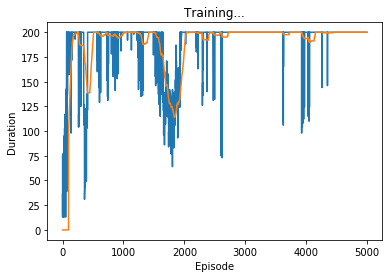

In [5]:
main()